# Homework №3

This homework will be dedicated to Keyword Spotting (KWS), streaming and speedup NN.

# Setup dependencies



In [ ]:
!pip install torch

In [ ]:
!pip install torchaudio==0.6.0

     |████████████████████████████████| 6.7MB 9.8MB/s 


In [ ]:
!pip install wandb

     |████████████████████████████████| 1.7MB 11.3MB/s 
     |████████████████████████████████| 163kB 51.2MB/s 
     |████████████████████████████████| 122kB 51.8MB/s 
     |████████████████████████████████| 102kB 14.8MB/s 
     |████████████████████████████████| 102kB 13.9MB/s 
     |████████████████████████████████| 71kB 11.8MB/s 
  Created wheel for watchdog: filename=watchdog-0.10.3-cp36-none-any.whl size=73873 sha256=2fa85bfe111f4b542c92cc9934a6d0f6a149882453703fed43aabba15b2c143d
  Stored in directory: /root/.cache/pip/wheels/a8/1d/38/2c19bb311f67cc7b4d07a2ec5ea36ab1a0a0ea50db994a5bc7
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6489 sha256=2cbcda7b5df43e1bc7a9590ca2312ef8e4a35e843640ee8192e183a03b042546
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp36-none-any.whl size=8785 sha256=52c99545f7f4f9c1fd3e87d9271585234f9d25d802

In [ ]:
import torch
import torchaudio
import pandas as pd
# import multiprocessing as mp
from torch import nn
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
# from google.colab import files

# %pylab inline
# from itertools import islice
# from scipy.signal import hann
# from scipy.io import wavfile


In [ ]:
import wandb
!wandb login 32f7df3c332802b239b3a621db53985fe17d319e
wandb.init(project="kws-implementation")

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Currently logged in as: maxthehuman (use `wandb login --relogin` to force relogin)


# Config

In [ ]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(7)
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
# mp.set_start_method('fork', True)
# mp.set_start_method('spawn', True)

cuda


In [ ]:
batch_size = 32
epochs = 200
n_mels = 40

freq_mask_param = 15
time_mask_param = 10


# Data

In [ ]:
import os
datadir = "speech_commands"

!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
# alternative url: https://www.dropbox.com/s/j95n278g48bcbta/speech_commands_v0.01.tar.gz?dl=1
!mkdir {datadir} && tar -C {datadir} -xvzf speech_commands_v0.01.tar.gz 1> log

samples_by_target = {
    cls: [os.path.join(datadir, cls, name) for name in os.listdir("./speech_commands/{}".format(cls))]
    for cls in os.listdir(datadir)
    if os.path.isdir(os.path.join(datadir, cls))
}
print('Classes:', ', '.join(sorted(samples_by_target.keys())[1:]))

--2020-11-02 09:57:03--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.7.240, 2607:f8b0:4004:802::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.7.240|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G   204MB/s    in 9.0s    

2020-11-02 09:57:12 (158 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]

Classes: bed, bird, cat, dog, down, eight, five, four, go, happy, house, left, marvin, nine, no, off, on, one, right, seven, sheila, six, stop, three, tree, two, up, wow, yes, zero


    Choose from 1 to 3 keywords to your liking, and use the rest as negative examples.
    We recommend to use sheila and/or marvin.

Let's use "marvin"

In [ ]:
for key in samples_by_target.keys():
  print(key, len(samples_by_target[key]))

yes 2377
cat 1733
six 2369
happy 1742
seven 2377
left 2353
no 2375
stop 2380
right 2367
wow 1745
_background_noise_ 7
zero 2376
marvin 1746
dog 1746
two 2373
nine 2364
tree 1733
sheila 1734
three 2356
eight 2352
house 1750
on 2367
bed 1713
one 2370
five 2357
four 2372
up 2375
go 2372
down 2359
bird 1731
off 2357


In [ ]:
len(samples_by_target)

31

In [ ]:
samples_by_target['marvin'][0:10]

['speech_commands/marvin/682e1687_nohash_1.wav',
 'speech_commands/marvin/881583a6_nohash_0.wav',
 'speech_commands/marvin/7014b07e_nohash_2.wav',
 'speech_commands/marvin/a527cb3c_nohash_1.wav',
 'speech_commands/marvin/98447c43_nohash_0.wav',
 'speech_commands/marvin/b843de62_nohash_1.wav',
 'speech_commands/marvin/8c888bbb_nohash_1.wav',
 'speech_commands/marvin/ef2a3cfb_nohash_0.wav',
 'speech_commands/marvin/7ff085e1_nohash_2.wav',
 'speech_commands/marvin/72198b96_nohash_0.wav']

In [ ]:
len(samples_by_target['marvin'])

1746

In [ ]:
COLUMN_NAMES=['wav_filename', 'class']
marvin_df = pd.DataFrame(columns=COLUMN_NAMES)
non_marvin_df = pd.DataFrame(columns=COLUMN_NAMES)

In [ ]:
i = 0
for filename in samples_by_target['marvin']:
  marvin_df.loc[i] = [filename, 1]
  i += 1

needed_len = len(samples_by_target['marvin']) // 29  # so that dataset contains equal quantity of two classes
i = 0
for key in samples_by_target.keys():
  if key != '_background_noise_' and key != 'marvin':
    for filename in samples_by_target[key][0:needed_len]:
      non_marvin_df.loc[i] = [filename, 0]
      i += 1

In [ ]:
marvin_df['class'] = marvin_df['class'].astype(int)
non_marvin_df['class'] = non_marvin_df['class'].astype(int)

In [ ]:
marvin_df

,wav_filename,class
0,speech_commands/marvin/682e1687_nohash_1.wav,1
1,speech_commands/marvin/881583a6_nohash_0.wav,1
2,speech_commands/marvin/7014b07e_nohash_2.wav,1
3,speech_commands/marvin/a527cb3c_nohash_1.wav,1
4,speech_commands/marvin/98447c43_nohash_0.wav,1
...,...,...
1741,speech_commands/marvin/300384f0_nohash_0.wav,1
1742,speech_commands/marvin/c0e8f5a1_nohash_1.wav,1
1743,speech_commands/marvin/4f2ab70c_nohash_0.wav,1
1744,speech_commands/marvin/65d14087_nohash_1.wav,1


In [ ]:
non_marvin_df

,wav_filename,class
0,speech_commands/yes/ce9410da_nohash_1.wav,0
1,speech_commands/yes/e53139ad_nohash_3.wav,0
2,speech_commands/yes/df1d5024_nohash_2.wav,0
3,speech_commands/yes/333784b7_nohash_1.wav,0
4,speech_commands/yes/16d41d07_nohash_0.wav,0
...,...,...
1735,speech_commands/off/1e4064b8_nohash_1.wav,0
1736,speech_commands/off/64574a99_nohash_0.wav,0
1737,speech_commands/off/ffd2ba2f_nohash_2.wav,0
1738,speech_commands/off/cb2929ce_nohash_3.wav,0


In [ ]:
train_marvin = marvin_df.sample(frac=0.9, random_state=21)
test_marvin = marvin_df.drop(train_marvin.index)

train_non_marvin = non_marvin_df.sample(frac=0.9, random_state=21)
test_non_marvin = non_marvin_df.drop(train_non_marvin.index)

train_set = pd.concat([train_marvin, train_non_marvin])
test_set = pd.concat([test_marvin, test_non_marvin])

# df = df.sample(frac=1).reset_index(drop=True)
train_set = train_set.sample(frac=1, random_state=22).reset_index(drop=True)
test_set = test_set.sample(frac=1, random_state=22).reset_index(drop=True)

print("train set size:", len(train_set), "\ntest set size:", len(test_set))

train set size: 3137 
test set size: 349


In [ ]:
mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=22050,
    n_fft=1024,
    win_length=1024,
    hop_length=256,
    f_min=0,
    f_max=8000,
    n_mels=n_mels).to(device)

In [ ]:
import IPython

IPython.display.Audio("speech_commands/marvin/cc592808_nohash_0.wav")  

In [ ]:
class MyDataset(Dataset):
    def __init__(self, data):
        super(MyDataset, self).__init__()
        self._data = data

    def __getitem__(self, index: int):
        wav_filename, true_class = self._data.iloc[index]
        # print("file:", wav_filename)
        # path_to_file = path_to_dataset + "wavs/" + wav_filename + ".wav"

        waveform, sample_rate = torchaudio.load(wav_filename)
        waveform = waveform.to(device)
        spectrogram = mel_transform(waveform)
        spectrogram = torch.log(spectrogram + 1e-9)

        return spectrogram, true_class

    def __len__(self):
        return len(self._data)

In [ ]:
train_dataset = MyDataset(train_set)
test_dataset = MyDataset(test_set)

1


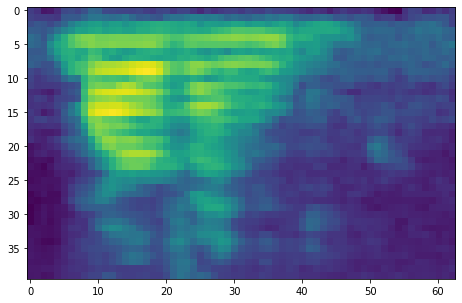

In [ ]:
plt.figure(figsize=(20, 5))
spectrogram, true_class = train_dataset.__getitem__(0)
print(true_class)
plt.imshow(spectrogram.cpu().squeeze())
plt.show()

In [ ]:
def augment(waveform):
    freq_transform = torchaudio.transforms.FrequencyMasking(freq_mask_param=freq_mask_param)
    time_transform = torchaudio.transforms.TimeMasking(time_mask_param=time_mask_param)
    return time_transform(freq_transform(waveform))

In [ ]:
def collate_sequences(batch, is_test = False):
    specs = []
    labels = []
    specs_len = []
    labels_len = []
    for (log_mel_spec, true_class) in batch:
        # print("true_class:", true_class)
        if not is_test:
            log_mel_spec = augment(log_mel_spec)
        specs.append(log_mel_spec.squeeze(0).transpose(0, 1))
        # specs_len.append(log_mel_spec.shape[-1]//2)
        # print(log_mel_spec.shape)
        # text_in_ints = torch.Tensor(text_transform(text_in_letters))
        labels.append(torch.LongTensor([true_class]))
        # labels_len.append(1)

    # print("labels before cat:", labels)
    specs = nn.utils.rnn.pad_sequence(sequences=specs, batch_first=True).transpose(1, 2)
    # labels = nn.utils.rnn.pad_sequence(sequences=labels, batch_first=True)
    labels = torch.cat(labels)
    # print("labels after cat:", labels)

    return specs, labels  # , specs_len, labels_len

In [ ]:
train_dataloader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            collate_fn=collate_sequences,
            num_workers=0
            # pin_memory=True
        )

test_dataloader = DataLoader(
            test_dataset,
            batch_size=batch_size,
            collate_fn=lambda x: collate_sequences(x, True),
            num_workers=0
            # pin_memory=True
        )

In [ ]:
print(len(train_dataloader))
print(len(test_dataloader))

99
11


# Model

In [ ]:
class CRNNEncoder(nn.Module):
    def __init__(self):
        super(CRNNEncoder, self).__init__()
        self.cnn = nn.Conv1d(
            in_channels=40, out_channels=64, kernel_size=20, padding=20//2
        )
        self.gru = nn.GRU(input_size=64, hidden_size=128)

    def forward(self, x):
        # print("0", x.shape)
        outputs = self.cnn(x)
        # print("1.1 outputs - after cnn", outputs.shape)
        # print("1.2 outputs.size(-1)", outputs.size(-1))
        # reshape for gru
        outputs = torch.transpose(outputs, 0, 2)
        outputs = torch.transpose(outputs, 1, 2)
        # print("1.2 outputs after transformation", outputs.shape)
        outputs, __ = self.gru(outputs)
        # reshape back
        # outputs = torch.transpose(outputs, 1, 2)
        # outputs = torch.transpose(outputs, 0, 2)
        outputs = torch.transpose(outputs, 0, 1)
		    ## from (1, N, hidden) to (N, hidden)
        # hiddens = hiddens.view(hiddens.size()[1], hiddens.size(2))
        # print("2.1 hiddens - after gru", hiddens.shape)
        # print("2.2 outputs - after gru and back transformation", outputs.shape)

        return outputs  # , hiddens


In [ ]:
class Attn(nn.Module):
    def __init__(self):
        super(Attn, self).__init__()
        self.main_fully_connected = nn.Linear(in_features=128, out_features=64)
        self.main_softmax = nn.Softmax(dim=-1)
        self.tanh = nn.Tanh()
        self.v = nn.Linear(64, 1)
        self.middle_softmax = nn.Softmax(dim=1)
        self.final_fully_connected = nn.Linear(in_features=128, out_features=2)
        self.final_softmax = nn.Softmax(dim=0)

    def forward(self, hiddens, streaming_mode):
        # print("0", hiddens.shape)
        x = self.main_fully_connected(hiddens)
        # print("1 after main fully conn", x.shape)
        x = self.main_softmax(x)
        # print("2 after main softmax", x.shape)
        x = self.tanh(x)
        # print("3 after tanh", x.shape)
        e = self.v(x)
        # print("4 e - after v", e.shape)
        a = self.middle_softmax(e)
        # print("5 a - after middle softmax", a.shape)
        # print("transposed shape", torch.transpose(hiddens[0], 0, 1).shape)
        # print("a[0] shape", a[0].shape)

        outputs = []
        for i in range(hiddens.shape[0]):
          outputs.append(torch.mm(torch.transpose(hiddens[i], 0, 1), a[i]))
        # outputs = torch.mm(torch.transpose(hiddens, 0, 1), a)
        outputs = torch.transpose(torch.cat(outputs, dim=1), 0, 1)
        # print("6 outputs - after mv", outputs.shape)
        outputs = self.final_fully_connected(outputs)
        # print("7 outputs - after final fully connected", outputs.shape)
        if not streaming_mode:
          outputs = self.final_softmax(outputs)
        # print("8 outputs - after final softmax", outputs.shape)
        return outputs


In [ ]:

class KWS(nn.Module):
    def __init__(self):
        super(KWS, self).__init__()
        
        self.encoder = CRNNEncoder()
        self.attention = Attn()

    def forward(self, x, streaming_mode = False):
        # x (batch, channel, feature, time)
        outputs = self.encoder(x)
        x = self.attention(outputs, streaming_mode)
        # x = x.transpose(1, 2)
        return x  # (batch, channel, feature, time)

In [ ]:
# test_model = KWS().to(device)

In [ ]:
# test_specs, test_labels = next(iter(test_dataloader))

In [ ]:
# print(test_labels)

# Train-Test pipeline

In [ ]:
model=KWS().to(device)
wandb.watch(model)

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(total_params)

134339


In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)

In [ ]:
def train(model, train_dataloader, criterion, optimizer, epoch):
    model.train()
    data_len = len(train_dataloader.dataset)
    losses = []
    correct = 0
    total = 0
    for batch_idx, (log_mel_specs, classes) in enumerate(train_dataloader):
        log_mel_specs = log_mel_specs.to(device)
        classes = classes.to(device)

        optimizer.zero_grad()

        output = model(log_mel_specs)  # (batch, time, n_class)
        __, predicted = torch.max(output, dim=1)
        correct += (predicted == classes).sum().item()
        total += classes.shape[0]
        
        loss = criterion(output, classes)
        loss.backward()
        losses.append(loss)

        optimizer.step()
        if batch_idx == 1 and epoch % 10 == 1:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(log_mel_specs), data_len,
                100. * batch_idx / len(train_dataloader), loss.item()))
    return sum(losses) / len(losses), correct / total

In [ ]:
def test(model, test_dataloader, criterion, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (log_mel_specs, true_class) in enumerate(test_dataloader):
            log_mel_specs = log_mel_specs.to(device)
            true_class = true_class.to(device)

            output = model(log_mel_specs)  # (batch, time, n_class)
            __, predicted = torch.max(output, dim=1)
            correct += (predicted == true_class).sum().item()
            total += true_class.shape[0]
            loss = criterion(output, true_class)
            test_loss += loss.item() / len(test_dataloader)

    print('Test set average loss: {:.4f}\n'.format(test_loss))
    return test_loss, correct / total


In [ ]:
# weights_file = wandb.restore('weights.pt')
# model.load_state_dict(torch.load(weights_file.name))

In [ ]:
for epoch in range(50):
  print("epoch:", epoch)
  train_avg_loss, train_accuracy = train(model, train_dataloader, criterion, optimizer, epoch)
  print("train accuracy:", train_accuracy)
  test_avg_loss, test_accuracy = test(model, test_dataloader, criterion, epoch)
  print("test accuracy:", test_accuracy)
  wandb.log({"Train loss": train_avg_loss,
             "Test loss": test_avg_loss,
             "Train accuracy": train_accuracy,
             "Test accuracy": test_accuracy})

model = model.to("cpu")
torch.save(model.state_dict(), os.path.join(wandb.run.dir, 'weights.pt'))
wandb.save('weights.h5')
# files.download('model_state_dict.pt')
model = model.to(device)
print("Saved model at last epoch")

epoch: 0
train accuracy: 0.6687918393369461
Test set average loss: 0.6714

test accuracy: 0.6876790830945558
epoch: 1
Train Epoch: 1 [32/3137 (1%)]	Loss: 0.675598
train accuracy: 0.7299968122409946
Test set average loss: 0.6670

test accuracy: 0.7822349570200573
epoch: 2
train accuracy: 0.8042715970672617
Test set average loss: 0.6651

test accuracy: 0.8051575931232091
epoch: 3
train accuracy: 0.8390181702263309
Test set average loss: 0.6647

test accuracy: 0.8510028653295129
epoch: 4
train accuracy: 0.8412496015301243
Test set average loss: 0.6641

test accuracy: 0.8424068767908309
epoch: 5
train accuracy: 0.8645202422696844
Test set average loss: 0.6640

test accuracy: 0.8882521489971347
epoch: 6
train accuracy: 0.8651577940707682
Test set average loss: 0.6639

test accuracy: 0.8681948424068768
epoch: 7
train accuracy: 0.8769525023908192
Test set average loss: 0.6638

test accuracy: 0.8739255014326648
epoch: 8
train accuracy: 0.8772712782913612
Test set average loss: 0.6640

test acc

In [ ]:
specs, labels = train_dataset.__getitem__(0)
specs = specs.to(device)
print(labels)
model(specs, streaming_mode=True)

1


tensor([[-4.4726,  6.6959]], device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
# torch.save(model.state_dict(), os.path.join(wandb.run.dir, 'weights.pt'))
# wandb.save('weights.h5')

[]

In [ ]:
def streaming_mode(sample):
  int window_size = 61

    In this homework assignment, you will need to implement a model for finding a keyword in a stream.

        1) https://www.dropbox.com/s/22ah2ba7dug6pzw/KWS_Attention.pdf
            It is recommended to implement the version with CNN because it is easy and improves the model.

        2) What about streaming?
           This model works differently during training and inferance.
           During training you have some fixed input and you know that it has a keyword (or not).
           During the inferance, you read the T frames and make a prediction on them. And the next step is to read the T+1 frame,
           run the neural network just for it, and make a prediction based on it and the T-1 of the previous frames.
           This way you don't make unnecessary calculations.

           So, your model should support streaming mode.
           To demonstrate the work in streaming mode, take two random audio tracks of 10-20 seconds and glue them together
           so that your keyword will be between them. Run the model through this glued track and draw how the probability of your keyword changing over time.

        3) A good KWS is a robust KWS, so we ask you to implement as many augmentations as possible.
           (bonus) Download any noise from YouTube and add it as a background noise to the positive data. This helps a lot in real life.
           P.S. Use https://www.youtube-dl.org/

        4) (bonus) Add more attentions and orthogonality regularization. https://arxiv.org/abs/1910.04500
        
        5) (bonus) Speedup you model! Implement distillation of your model, for example,
            train the LSTM with 256 hidden size and distil it into LSTM with 128 hidden size.

# Code

    1) In this homework you are allowed to use pytorch-lighting.

    2) Try to write code more structurally and cleanly!
    
    3) Good logging of experiments save your nerves and time, so we ask you to use W&B. Log loss, FA/FR rate or something else.
        Do not remove the logs until we have checked your work and given you a grade!
    
    4) (Bonus) We also ask you to organize your code in github repo with Docker and setup.py. You can use my template https://github.com/markovka17/dl-start-pack.
    
    5) Your work must be reproducable, so fix seed, save the weights of model, and etc.
    
    6) In the end of your work write inference utils. Anyone should be able to take your weight, load it into the model and run it on some audio track.